In [ ]:
import pandas as pd
import numpy as np
import os
import time
from sklearn.metrics import confusion_matrix
import seaborn as sns

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision.io import read_image
from __future__ import print_function
from __future__ import division
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import ImageReadMode
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR
import os
import copy
from torchvision.models import ResNet18_Weights
from sklearn.metrics import classification_report
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)


PyTorch Version:  1.12.1
Torchvision Version:  0.13.1


In [ ]:
class GAFImageDataset(Dataset):
    def __init__(self, img_labels, img_dir, split="train", transform=None, target_transform=None):
        self.img_labels = img_labels[img_labels["split"] == split]
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def class2label(self, cls):
        label_map = {'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'ctrl': 4}
        label = label_map[cls]
        return label

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx]['image_name'])
        image = read_image(img_path, mode=ImageReadMode.RGB)
        label_str = self.img_labels.iloc[idx]['class']
        label = self.class2label(label_str)

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
path = r"D:\drug"

In [ ]:
metadata = pd.read_csv(os.path.join(path, 'metadata.csv'), index_col=[0,1,2,3]).sort_index()

metadata

drug class  split  \
plate        row col beat                       
2021.08.19   A   1   0      ctrl  ctrl  train   
                     1      ctrl  ctrl  train   
                     2      ctrl  ctrl  train   
                     3      ctrl  ctrl  train   
                     4      ctrl  ctrl  train   
...                          ...   ...    ...   
2022.09.20_A H   10  24    E4031   III  train   
                     25    E4031   III  train   
                     26    E4031   III  train   
                     27    E4031   III  train   
                     28    E4031   III  train   

                                                  image_name  
plate        row col beat                                     
2021.08.19   A   1   0         ('2021.08.19', 'A', 1, 0).png  
                     1         ('2021.08.19', 'A', 1, 1).png  
                     2         ('2021.08.19', 'A', 1, 2).png  
                     3         ('2021.08.19', 'A', 1, 3).png  
                     4         ('2021.08.19', 'A', 1, 4).png  
...                                                      ...  
2022.09.20_A H   10  24    ('2022.09.20_A', 'H', 10, 24).png  
                     25    ('2022.09.20_A', 'H', 10, 25).png  
                     26    ('2022.09.20_A', 'H', 10, 26).png  
                     27    ('2022.09.20_A', 'H', 10, 27).png  
                     28    ('2022.09.20_A', 'H', 10, 28).png  

[68035 rows x 4 columns]

In [ ]:
metadata['drug'].value_counts()

ctrl           20769
quinidine      12428
E4031          12383
verapamil      11696
propranolol    10759
Name: drug, dtype: int64

In [ ]:
train_data = GAFImageDataset(metadata, os.path.join(path, 'gaf'), "train")
val_data = GAFImageDataset(metadata, os.path.join(path, 'gaf'), "val")
test_data = GAFImageDataset(metadata, os.path.join(path, 'gaf'), "test")

In [ ]:
batch_size = 200

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

Feature batch shape: torch.Size([200, 3, 200, 200])
Labels batch shape: 200


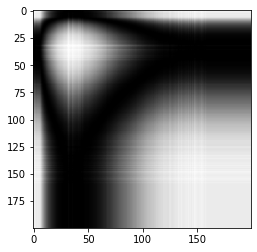

Label: 0


In [ ]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {len(train_labels)}")
img = train_features[0].squeeze().transpose(2,0)
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

# Defining accuracy metric assessments

In [ ]:
train_dataloader.dataset.img_labels

drug class  split  \
plate        row col beat                       
2021.08.19   A   1   0      ctrl  ctrl  train   
                     1      ctrl  ctrl  train   
                     2      ctrl  ctrl  train   
                     3      ctrl  ctrl  train   
                     4      ctrl  ctrl  train   
...                          ...   ...    ...   
2022.09.20_A H   10  24    E4031   III  train   
                     25    E4031   III  train   
                     26    E4031   III  train   
                     27    E4031   III  train   
                     28    E4031   III  train   

                                                  image_name  
plate        row col beat                                     
2021.08.19   A   1   0         ('2021.08.19', 'A', 1, 0).png  
                     1         ('2021.08.19', 'A', 1, 1).png  
                     2         ('2021.08.19', 'A', 1, 2).png  
                     3         ('2021.08.19', 'A', 1, 3).png  
                     4         ('2021.08.19', 'A', 1, 4).png  
...                                                      ...  
2022.09.20_A H   10  24    ('2022.09.20_A', 'H', 10, 24).png  
                     25    ('2022.09.20_A', 'H', 10, 25).png  
                     26    ('2022.09.20_A', 'H', 10, 26).png  
                     27    ('2022.09.20_A', 'H', 10, 27).png  
                     28    ('2022.09.20_A', 'H', 10, 28).png  

[47681 rows x 4 columns]

In [ ]:
def beat2sample_pred(y_true, y_pred, index):
      ### parameters
    # y_true should have shape (# of beats, # of class)
    # y_pred should have shape (# of beats, # of class)
    # index should be a pd.MultiIndex with 3 levels in order: 'plate','row','col' with length # of beats


    # we need to make y_pred's elements only consist of 0 and 1 where argmax is 1 and rest are 0
    new_y_pred = np.zeros(y_pred.shape)
    new_y_pred[range(y_pred.shape[0]), np.argmax(y_pred,axis=1)] = 1

    # y_pred at the sample level where each beat is weighted equally
    y_pred_sample = pd.DataFrame(new_y_pred, index = index).groupby(['plate','row','col']).mean().sort_index()

    # format y_true so that it is at the sample level
    y_true_sample = pd.DataFrame(y_true, index = index).reset_index().drop('beat',axis=1).drop_duplicates().set_index(['plate','row','col']).sort_index()
    return y_true_sample, y_pred_sample, y_true_sample.index

def beat_accuracy(y_true, y_pred, index=None):
    ### parameters
    # y_true should have shape (# of beats, # of class)
    # y_pred should have shape (# of beats, # of class)
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    if len(y_true.shape) == 2:
        if y_true.shape[1] == 1:
            y_true = y_true.flatten()
        else:
            y_true = np.argmax(np.array(y_true), axis=1)
    if len(y_pred.shape) == 2:
        if y_pred.shape[1] == 1:
            y_pred = y_pred.flatten()
        else:
            y_pred = np.argmax(np.array(y_pred), axis=1)
    correct_count = (y_true==y_pred).sum()
    all_count = len(y_true)
    return correct_count / all_count *100

def sample_accuracy(y_true, y_pred, index):
    y_true_sample, y_pred_sample, _ = beat2sample_pred(y_true, y_pred, index)

    # then call the same function as above to assess
    return beat_accuracy(y_true_sample.to_numpy(), y_pred_sample.to_numpy())

# Evaluation function
def evaluate_model(test_dataloader,index,model, export=False):


    label_map = {'I': 0, 'II': 1, 'III': 2, 'IV': 3, 'ctrl': 4}
    y_test = [label_map[i] for i in test_dataloader.dataset.img_labels["class"]]

    classes = np.array(['I',"II", "III","IV", "ctrl"])


    inverse_map = {0:'I', 1:'II',  2:'III', 3:'IV',  4:'ctrl'}
    with torch.no_grad():
        model.eval()
        prediction_proba = torch.empty(0).cuda()
        for data in test_dataloader:
            inputs, outputs = data
            prediction_proba=torch.cat((prediction_proba, model(inputs.to(torch.float32).cuda())))
    prediction_proba = prediction_proba.cpu()
    y_pred=np.argmax(prediction_proba,axis=1)
    print("Beat accuracy: %.2f%%" % beat_accuracy(y_test, y_pred))
    cfn_matrix = confusion_matrix(y_test, y_pred)
    xticklabels = classes
    yticklabels = classes
    sns.heatmap(cfn_matrix, annot = True, xticklabels = xticklabels, yticklabels=yticklabels)
    plt.title("Beat level confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

    print(classification_report(y_test, y_pred, target_names=classes))



    y_true_sample, y_pred_sample, index_sample = beat2sample_pred(y_test, prediction_proba, test_dataloader.dataset.img_labels.index)
    cfn_matrix_sample = confusion_matrix(y_true_sample.to_numpy(), np.argmax(y_pred_sample.to_numpy(), axis=1))
    print("Sample accuracy: %.2f%%" % beat_accuracy(y_true_sample, y_pred_sample))
    sns.heatmap(cfn_matrix_sample, annot = True, xticklabels = xticklabels, yticklabels=yticklabels)
    plt.title("Sample level confusion matrix")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.show()

    print(classification_report(y_true_sample.to_numpy(), np.argmax(y_pred_sample.to_numpy(), axis=1), target_names=classes))

    if export:
        os.makedirs(export, exist_ok=True)
        cfn_matrix_frame = pd.DataFrame(cfn_matrix, index=np.core.defchararray.add("True ",classes), columns=np.core.defchararray.add("Pred ",classes)).to_csv(os.path.join(export, "beat_confusion_matrix.csv"))
        cfn_matrix_sample_frame = pd.DataFrame(cfn_matrix_sample, index=np.core.defchararray.add("True ",classes), columns=np.core.defchararray.add("Pred ",classes)).to_csv(os.path.join(export, "sample_confusion_matrix.csv"))
        pd.DataFrame(classification_report(y_true_sample.to_numpy(), np.argmax(y_pred_sample.to_numpy(), axis=1), target_names=classes, output_dict=True)).T.to_csv(os.path.join(export, "sample_clsf_summary.csv"))
        pd.DataFrame(classification_report(y_test, y_pred, target_names=classes, output_dict=True)).T.to_csv(os.path.join(export, "beat_clsf_summary.csv"))
        wrong_index = pd.DataFrame()
        wrong_index['true'] = test_dataloader.dataset.img_labels["class"]
        wrong_index['pred'] = [inverse_map[i] for i in np.argmax(np.array(prediction_proba),axis=1)]
        wrong_index['correct'] = (np.array(y_test) == np.argmax(np.array(prediction_proba),axis=1))
        wrong_index.to_csv(os.path.join(export, "misclassified.csv"))




# Model

In [ ]:
norm_factor = np.sqrt(np.square(train_data.img_labels['class'].value_counts()[['I','II','III','IV','ctrl']]).sum()/5)

In [ ]:
class_weight = norm_factor/torch.Tensor(train_data.img_labels['class'].value_counts()[['I','II','III','IV','ctrl']]).cuda()

In [ ]:

# Number of classes in the dataset
num_classes = 5


# Number of epochs to train for
num_epochs = 200

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = True


In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def train_model(model, dataloaders, criterion, scheduler, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_loss = float("inf")

    early_stopper = EarlyStopper(patience=10, min_delta=0.01)
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                inputs = inputs.float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)


            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            if scheduler and phase =="val" and optimizer.param_groups[0]['lr'] > 1e-6:
                scheduler.step()
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Learning rate: ",optimizer.param_groups[0]['lr'])

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
        if early_stopper.early_stop(epoch_loss):
            break
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))
    print('val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:
#set param.requires_grad = False to freeze the parameters for fine tuning
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
    else:
        for param in model.parameters():
            param.requires_grad = True

In [ ]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 200

    elif model_name == "resnet50":
        """ Resnet
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 200

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 200

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 200

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 200

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 200

    elif model_name == "vitb16":

        model_ft = models.vit_b_16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.heads.head.in_features
        model_ft.heads.head = nn.Linear(num_ftrs, num_classes)
        input_size = 200

    elif model_name == "vitl16":

        model_ft = models.vit_l_16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.heads.head.in_features
        model_ft.heads.head = nn.Linear(num_ftrs, num_classes)
        input_size = 200
    elif model_name == "vitb32":

        model_ft = models.vit_b_32(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.heads.head.in_features
        model_ft.heads.head = nn.Linear(num_ftrs, num_classes)
        input_size = 200

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size


In [ ]:
image_datasets = {"train": train_data,
                    "val": val_data}
dataloaders_dict = {"train": train_dataloader,
                    "val": val_dataloader}


# Repeat model training 5 times for each model

GAF\resnet_no_pretrain_5
Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.

C:\Users\YBLab\Anaconda3\envs\mlenv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


train Loss: 0.8889 Acc: 0.6599
Learning rate:  1e-05
val Loss: 0.6638 Acc: 0.7560
Learning rate:  9.5e-06

Epoch 1/199
----------
train Loss: 0.4770 Acc: 0.8375
Learning rate:  9.5e-06
val Loss: 0.5076 Acc: 0.8052
Learning rate:  9.025e-06

Epoch 2/199
----------
train Loss: 0.3104 Acc: 0.8996
Learning rate:  9.025e-06
val Loss: 0.4493 Acc: 0.8290
Learning rate:  8.57375e-06

Epoch 3/199
----------
train Loss: 0.2189 Acc: 0.9330
Learning rate:  8.57375e-06
val Loss: 0.4757 Acc: 0.8404
Learning rate:  8.1450625e-06

Epoch 4/199
----------
train Loss: 0.1653 Acc: 0.9518
Learning rate:  8.1450625e-06
val Loss: 0.4243 Acc: 0.8560
Learning rate:  7.737809375e-06

Epoch 5/199
----------
train Loss: 0.1295 Acc: 0.9640
Learning rate:  7.737809375e-06
val Loss: 0.4751 Acc: 0.8524
Learning rate:  7.35091890625e-06

Epoch 6/199
----------
train Loss: 0.1012 Acc: 0.9756
Learning rate:  7.35091890625e-06
val Loss: 0.4860 Acc: 0.8490
Learning rate:  6.9833729609374995e-06

Epoch 7/199
----------
tra

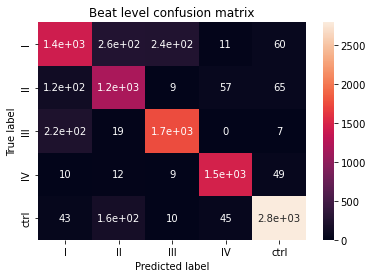

              precision    recall  f1-score   support

           I       0.78      0.71      0.74      2000
          II       0.72      0.82      0.77      1426
         III       0.87      0.87      0.87      1998
          IV       0.93      0.95      0.94      1544
        ctrl       0.94      0.92      0.93      3051

    accuracy                           0.86     10019
   macro avg       0.85      0.85      0.85     10019
weighted avg       0.86      0.86      0.86     10019

Sample accuracy: 87.50%


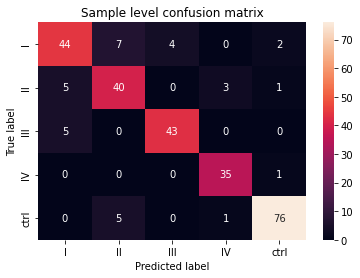

              precision    recall  f1-score   support

           I       0.81      0.77      0.79        57
          II       0.77      0.82      0.79        49
         III       0.91      0.90      0.91        48
          IV       0.90      0.97      0.93        36
        ctrl       0.95      0.93      0.94        82

    accuracy                           0.88       272
   macro avg       0.87      0.88      0.87       272
weighted avg       0.88      0.88      0.87       272



In [ ]:
for model_name in ["resnet", "vgg", "squeezenet", "densenet"]:

    #for pretrain in [True, False]:
    for pretrain in [False]:
        #for iteration in range(1,5):
        for iteration in [5]:
            export_folder = "GAF\\"+model_name + "_"
            if not pretrain:
                export_folder += "no_"
            export_folder += "pretrain_" + str(iteration)
            print(export_folder)
            device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

            if pretrain:
                ########
                # fine tuning
                #finetune
                feature_extract = True
                # Initialize the model for this run
                model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrain)

                ########
                #Optimizer
                # Send the model to GPU
                model_ft = model_ft.to(device)

                params_to_update = model_ft.parameters()
                print("Params to learn:")
                if feature_extract:
                    params_to_update = []
                    for name,param in model_ft.named_parameters():
                        if param.requires_grad == True:
                            params_to_update.append(param)
                            print("\t",name)
                else:
                    for name,param in model_ft.named_parameters():
                        if param.requires_grad == True:
                            print("\t",name)

                # Observe that all parameters are being optimized
                optimizer_ft = optim.AdamW(params_to_update, lr=0.005)
                scheduler=None
                # Setup the loss fxn
                criterion = nn.CrossEntropyLoss(weight=class_weight)

                # Train and evaluate
                model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, scheduler, optimizer_ft, num_epochs=1, is_inception=(model_name=="inception"))
            else:

                model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=pretrain)
            #####
            #unfreeze and train whole network
            feature_extract = False
            set_parameter_requires_grad(model_ft, feature_extract)

            ######
            # Send the model to GPU
            model_ft = model_ft.to(device)

            # Gather the parameters to be optimized/updated in this run. If we are
            #  finetuning we will be updating all parameters. However, if we are
            #  doing feature extract method, we will only update the parameters
            #  that we have just initialized, i.e. the parameters with requires_grad
            #  is True.
            params_to_update = model_ft.parameters()
            print("Params to learn:")
            if feature_extract:
                params_to_update = []
                for name,param in model_ft.named_parameters():
                    if param.requires_grad == True:
                        params_to_update.append(param)
                        print("\t",name)
            else:
                for name,param in model_ft.named_parameters():
                    if param.requires_grad == True:
                        print("\t",name)

            # Observe that all parameters are being optimized
            if model_name=="squeezenet":
                optimizer_rt = optim.AdamW(params_to_update, lr=1e-4)
                scheduler = ExponentialLR(optimizer_rt, gamma=0.95)
            else:
                optimizer_rt = optim.AdamW(params_to_update, lr=1e-5)
                scheduler = ExponentialLR(optimizer_rt, gamma=0.95)


            model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, scheduler, optimizer_rt, num_epochs=num_epochs, is_inception=(model_name=="inception"))


            evaluate_model(test_dataloader,test_dataloader.dataset.img_labels.index,model_ft, export=export_folder)
            torch.save(model_ft.state_dict(), os.path.join(export_folder, "model.pt"))
